<!-- Title: -->
<div align="center">
  <h1><b> Artificial Neural Networks</b>
  <h2><b>Theory</b></h2>
</div>
<br>

In [ ]:
import matplotlib.pyplot as plt
from typing import List
import tensorflow as tf
from numpy import exp
from math import log2
import numpy as np

# <font color='orange'> Blueprint of a Neural Network </font><a name="Implementation" />

## Type of Models

- **Discriminative model:** these models aim to learn the boundary between classes. They focus on modeling the conditional probability $P(y | x)$, where $x$
is the input data and $y$ is the label or output. The goal is to directly predict the label or output given the input data. Examples: BERT (bidirectional and encoder-based) used to predict hidden words in a sentence, text classification tasks, sentiment prediction and document categorization.

- **Generative model:** these models focus on modeling the joint probability $P(x,y)$. Examples: Naive Bayes, Gaussian Mixture Models (GMM), Hidden Markov Models (HMM), GPT (decoder-based), and T5.

- **Bidirectional model:** the model takes into account the context from both the left (preceding words) and the right (following words) of a given word in a sentence during training and inference.

## Architecture

- **Layers:**
    - **Input layer:** the first layer of the neural network (NN) containing one or more neurons where each neuron corresponds to a single normalized (preprocessed) feature of the input data.
    - **Hidden layer:** common name given to all layers located between the input layer and the output layer.
    - **Output layer:** is the final layer of the neural network that produces the network's predictions, and it contains a number of neurons (also known as units) corresponding to the number of output classes or features to be predicted in the task being solved.
    - **Dense layer:** are fully-connected feedforward layers, i.e., each neuron in the previous layer is connected to every neuron in the next layer.
    - **Convolutional layer:** a layer that applies filters (a.k.a kernels) to input data to detect features (edges, textures, shapes) and patterns. These filters are trainable parameters, which means their values are updated during the training process to learn relevant features from the data. Works well for structured data such as images due to, but not only, translation invariance.
    - **Dense blocks a.k.a densely connected convolutional layers:** the output feature map of each layer is concatenated with the output of all preceding layers along the channel dimension and fed as input to the next layer.

- **Neurons:** units of the NN used to store a value. A single layer of the NN could have one or more such neurons.

- **Weights a.k.a synapses:** are the trainable parameters in a neural network that represent the strengths of connections between neurons and are adjusted during the training/optimization process. If a Dense layer $l_j$ has $n$ neurons and the previous layer $l_{j-1}$ has $m$ neurons, then there will be a total of $n*m$ weight (synapse) connections between the two layers, i.e, $n*m$ values in the weight matrix.

- **Bias:** is an additional constant term added to the weighted sum of inputs for each neuron in a layer, i.e, there is one bias per neuron in a `Dense layer`.

- **Activation function:** is a non-linear function applied to the output of each neuron in a layer. It introduces non-linearity to the model, allowing it to learn complex patterns in the data. In a `Dense layer`, each neuron has its own activation function applied to its input value, which produces the neuron's output that is passed to the next layer as the input.

- **Loss function a.k.a error function:** the target function to be minimized so that predicted values get closer and closer to ground truth values.

- **Techniques:** dropout, batch normalization, skip connection, residual block, Max Pooling, Max Unpooling, weight initialization, etc.

- **Mixture of Experts (MoE)**: is a neural network architecture where multiple "experts" (which are typically feedforward layers) are trained in parallel.
    - In LLMs, the `feedforward layer` of the transformer block is replaced with N other feedforward layers or experts. The input is offloaded to the different experts through a routing mechanism.
    - The `mixture part refers to a gating mechanism` that dynamically selects which expert to activate based on the input's characteristics. This contrasts to a traditional multi-headed attention network, where each head usually processes the same data or task.
    - The model is trained on a single large dataset where different experts specialize in different features or regions of the data.
    - This helps scale large AI models efficiently by activating only a subset of the total parameters during inference.
    - `Dense MOE`: input tokens are distributed across all experts, i.e., all experts in the model are active simultaneously for each input token. Outputs are then combined using a gating mechanism. This is computationally expensive and does not scale well.
    - `Sparse MOE`: only a subset of experts is activated per input. Much more efficient, as fewer experts are used per inference.
 
**Question:** How does the gating mechanism of mixture of experts knows which model to select based on the input's characteristics?

**Answer:** the gating (a.k.a router) function is a Feedforward Neural Network (FFNN) trained alongside the experts, allowing it to learn optimal routing strategies based on input features.

The gating FFNN outputs a matrix of weights $H(x)$:

$$ H_i(x) =  (W_i x_{i-1} + b_i) $$

The router mechanism then outputs a probability distribution over the available experts. For each expert there is a prob. dist. given by:

$$ g_i(x) = \text{Softmax } (H_i(x))$$

The final output is a weighted sum of the expert outputs:

$$ y = \sum_i g_i(x) E_i (x)$$

where $E_i(x)$ is the output of expert $i$ and $g_i(x)$ is its assigned probability determined by the gating mechanism.

- [Hydra-MoE](https://huggingface.co/HydraLM): ...

## Number of trainable parameters per layer

Trainable parameters are the weights and the biases.

- **Activation function:** 0 (no trainable parameters).

- **Dense layer:** (input_size + 1 bias) * number_of_neurons.

- **Bias:** 1*number_of_neurons in the current layer.

- **Flatten:** 0 (no trainable parameters).
<br>

- **Conv2D layer:** (filter_height * filter_width * input_channels + 1 bias) * number_of_filters.

Example: 

```python
nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1, stride=1, bias=True)
```

- Input channels ($C_{in}$): 1.
- 0utput channels ($N_{filters}$): 32.
- Kernel size (height x width): 3x3.
- Each filter (output channel) has one bias term.
- Padding and stride do not affect the number of parameters, they only determine the output dimensions of the feature map.
- 
Total parameters: (3x3x1+1)x32 = 320. 

## Encoding

When dealing with multi-class classification in deep learning, one-hot encoding isn't always the best approach, especially when the number of classes is large. Here are alternative methods:
 
- `Label Encoding (a.k.a Integer Encoding)`:
    - Assigns a unique integer to each class.
    - Useful for tree-based models but problematic for neural networks due to ordinal relationships being introduced.

- `Target Encoding (a.k.a Mean Encoding)`:
   - Replaces each categorical input variable (not the target) with the mean of the target variable using only the training data. The target should have a meaningful average per category (e.g., customer churn rate, average price).
   - It can lead to data leakage if the entire dataset (training, validation, and test sets) is used to calculate the mean if it is not handled properly (e.g., using K-fold cross-validation).

- Example of a simple logistic regression model with one neuron for a binary classification task such as predicting the churn (0 or 1):
    - Input categorical variable: "Subscription Plan" (Basic, Standard, Premium).
    - Target variable: "Churn" (1: 'Customer left', 0: 'Customer stayed')
    - Activation function: sigmoid (binary classification).
    - Loss: Binary Cross-Entropy Loss.

| Customer ID | Subscription Plan | Churn |
| ----------- | ----------------- | ----- |
| 1           | Basic             | 1     |
| 2           | Standard          | 0     |
| 3           | Standard          | 1     |
| 4           | Premium           | 0     |
| 5           | Premium           | 1     |
| 6           | Premium           | 0     |

1. **Calculate the mean of the target variable:**

- Basic: (1) / 1 = 1
- Standard: (0 + 1) / 2 = 0.5
- Premium: (0 + 1 + 0) / 3 = 0.333

2. **Replace categorical values with encoded values:**

| Customer ID | Subscription Plan | Churn | Encoded Plan (x) |
| ----------- | ----------------- | ----- | ------------------------------ |
| 1           | Basic             | 1     | 1                          |
| 2           | Standard          | 0     | 0.5                          |
| 3           | Standard          | 0     | 0.5                          |
| 4           | Premium           | 0     | 0.333                          |
| 5           | Premium           | 1     | 0.333                          |
| 6           | Premium           | 0     | 0.333                          |

3. **Computing weighted sum $s=w⋅x+b$ and activation $\hat{y} = \sigma(s)$.**

Setting $w = 4.0$ and $b=-1.5$:

| Customer ID | Encoded Plan (x) | s = wx + b | $\hat{y}$ (predicted prob) | $y$ (groun truth - churn) |
| ----------- | ---------------- | ---------- | -------------------------- | ---------- |
| 1           | 1                | 2.5        | 0.924                      | 1          |
| 2           | 0.5              | 0.5        | 0.622                      | 0          |
| 3           | 0.5              | 0.5        | 0.622                      | 0          |
| 4           | 0.333            | -0.168     | 0.458                      | 0          |
| 5           | 0.333            | -0.168     | 0.458                      | 1          |
| 6           | 0.333            | -0.168     | 0.458                      | 0          |

4. **Computing the Binary Cross-Entropy Loss:**

$$BCE_{loss} = \frac{1}{N}\sum_{i=1}^N BCE(y_i, \hat{y}_i) = - \frac{1}{6}\sum_{i=1}^6 y_i \cdot \mathrm{log}\; {\hat{y}}_i + (1-y_i) \cdot \mathrm{log}\; (1-{\hat{y}}_i) \approx ...$$

In [27]:
s = -0.168
activation = 1/(1+np.exp(-s))
activation

0.4580985059860437

- `Word Embeddings (for Categorical Data)`:
    - Trainable embeddings that map categories into continuous vector spaces.
    - Helps capture semantic relationships between categories.
    - Used in NLP but can be applied to general categorical data.
 
In LLMs:

- `Token embedding (a.k.a context vector):` is the representation (encoding) of a token by a continuous vector in a vector space. For autoregressive models (e.g., GPT), which predict one word at a time, the input-target pairs are generated on-the-fly with the sliding window approach.

## Learning

- **Pre-training:** training the model on a particular dataset before fine-tuning.

- **Transfer learning:** the neural network architecture and pre-trained weights of a pre-trained model are used as the backbone of a new neural network model. The final layer(s) of this new model is(are) then adjusted (e.g., changing the activation function) to match the desired task. The pre-trained weights can be frozen to retain their original feature representations, while the new layers are trained to adapt to the new task. Finally, pre-trained weights can be unfrozen and updated during the final training.

- **RLHF (reinforcement learning with human feedback):** a method to improve the model's performance based on human feedback.
- **Zero-shot learning:** the model is able to generalize to unseen tasks without prior examples.
- **Few-shot learning:** the model is able to learn from a small number of examples provided as input.
- **Few-shot setting:** when examples of the target are provided in the input.
- **Zero-shot setting:** no examples of the target are provided in the input.

## Fine-tuning

- **Fine-tuning**: is a subset of transfer learning. It is a broader term that encompasses any method of adapting a `pretrained model` to a new task, typically using a specific `labeled dataset`. The existing model is initialized with its pretrained weights (e.g., a model trained on ImageNet for images or a large corpus for NLP). A labeled dataset specific to the target task is used. Some or all of the weights are updated during training.

- **Regular fine-tuning**: the pretrained weights are directly updated during training, and the entire model (including the updated weights) is saved.

- **Instruction fine-tuning**: consists of instruction-answer pairs. For example, an input text in English and the corresponding translated version in Chinese.

- **Classification fine-tuning**: consists of input-label pairs. For example, input email with corresponding label (spam or non-spam).

- **Low-Rank Adaptation (LoRA)**: is a Parameter-Efficient Fine-Tuning method designed to make fine-tuning more efficient by training only low-rank matrices ($W_A$ and $W_B$) instead of the entire model, while keeping the pre-trained weights frozen.
    - The idea behind LoRA is to reduce memory usage and computational overhead by training only the low-rank matrices rather than the full pretrained matrix of weights.
    - LoRA's approach is particularly useful for tasks requiring adaptation to new data with limited computational resources, as it avoids storing and fine-tuning the entire pretrained matrix of weights.

# <font color='orange'> Rule-of-Thumbs </font><a name="Implementation" />

1. `Ockham's razor:` when there are two competing theories that make exactly the same predictions, the simpler one is better. In model complexity, the more complex the model, the more prone the model is to overfitting as the size of the dataset decreases. Therefore, one should always start with a baseline model.

2. `Learning principle:` random features (noise) cannot be learned. In a data-driven approach, the dataset must share a pattern of meaningful representation.

3. `Hold-out set:` it is a good practice to split the dataset into training, test, and validation.

4. `Dataset size:` the larger the dataset, the higher the generalization of the model to unseen data.

5. `Network depth:` the deeper the network (number of layers), the more information is extracted (learned).

6. `Bias-variance trade-off:` while under-parametrization can cause bias (underfitting), over-parametrization can cause variance (overfitting). In mainstream machine learning, one tries to find a balance.

7. `Double descent:` over-parametrization beyond certain interpolation threshold can lead to model generalization (good test performance). Moreover, as the size of the parameter vector to be optimized increases (as large as one million), the local minima get closer to the global minimum.

8. `Batch size:` a larger batch size (increase memory resource) leads to a speed up in training and to a lower asymptotic test accuracy (classification), and hence a lower generalization to unseen data.

9. `Learning rate:` a higher learning rate can speed-up training, however, too large a learning rate can make the loss function value to jiggle around the loss landscape and to never converge.

# <font color='orange'> Challenges in Neural Networks </font><a name="Implementation" />

## Overfitting

- Overfitting occurs when the model has become too complex and has started to memorize the training data, leading to poor generalization performance on unseen data.
- It can be seen when the training loss/accuracy is getting better over time while the validation loss/accuracy is degrading.

## Underfitting

- Underfitting occurs when the model is too simple or when the training dataset is too shallow. 
- It appears when both training loss/accuracy and validation loss/accuracy are degrading.

## Vanishing Gradient

Vanishing gradient refers to a situation where the gradients of the loss function with respect to the weights become extremely small during the training process. 

This typically happens in deep neural networks with `many layers`, especially when using activation functions with derivatives that are close to zero, such as the `sigmoid or tanh` functions. As the value of the gradients goes to zero, they fail to provide information for weights update, leading to `slow or stalled learning`.

## Exploding Gradient

The exploding gradient happens when the gradients of the loss function with respect to the weights become extremely large during training. 

This can happen in deep neural networks using `large learning rates` in the optimization process. The excessively large gradients lead to large updates to the model parameters. This will make the optimization overshoot the minima and compromise the convergence of weights to their optimal value, consequently causing `instability and erratic learning behavior`. 

# <font color='orange'> Techniques to Address the Challenges </font><a name="Implementation" />

Popular techniques used in modern neural networks.

## Weight initialization

Weight initialization is a procedure used to set appropriate initial values to the weights in the neural network, aiming to keep the variance of activations constant across layers. A good initialization helps to prevent vanishing and exploding gradients.

Examples of initialization strategies include `Xavier` (also known as Glorot), `He`, and `LeCun`, each of which can use either a `normal` or `uniform` distribution variant. Normal and Uniform are types of distributions used in different initializations, not initialization strategies by themselves.

## Batchnormalization

- Batchnormalization: used to normalize the outputs of the previous layer to have zero mean and unit variance by subtracting the batch mean and dividing by the batch standard deviation for each batch of outputs.
- This helps with `training stability`, can `speed up training`, and `prevents overfitting` by adding noise to the outputs.

Note: in both fully connected and convolutional layers, `Batchnormalization` is typically applied after the affine transformation (i.e., $Wx + b$) or the convolution operation). While `Batchnormalization` is typically applied before the activation function (e.g., Conv → BN → ReLU), this is not a strict rule.

## Dropout

- Dropout: is a regularization used to `prevent overfitting` (increasing generalization) by randomly deactivating neurons during training.
- It also reduces the need for `early stopping`.

Note: it is generally not recommended to apply `Dropout` immediately after `Batchnormalization` in the same layer/block, as their effects can interfere. However, using both in different parts of the model can lead to better performance. In this case, `Batchnormalization` is generally applied before `Dropout`. In Keras (Functional API), `Dropout` is typically applied after the activation function.

## Skip Connection

A general term used to describe any connection in a neural network that bypasses one or more layers. These can take several forms:

- Element-wise addition of the input to the output (e.g., as in ResNets).
- Concatenation of input and output (e.g., as in DenseNets and U-Nets).
- Direct copying or routing of features from earlier to later layers.

Skip connections in `U-Nets` connect corresponding layers in the encoder and decoder paths. This facilitates:

- Transfer of low-level spatial features from the encoder (downsampling path).
- Recovery of spatial resolution and fine-grained details during the decoder (upsampling path).
- Better segmentation output due to preserved localization information.

Residual Block (a.k.a. Residual Layer) is a specific type of skip connection introduced in `ResNets`. The core idea is:

- The input tensor is added element-wise to the output of a few stacked layers (typically 2 or 3 convolutions),
- This is often called a shortcut connection or identity mapping.

- Example of basic residual block with two convolutional layers:
    - Input → Conv → Activation → Conv → Output.
    - Add input to the output of the second Conv layer.
    - The sum is optionally passed through a final activation function (e.g., ReLU).
 
This structure helps:

- Mitigate vanishing gradients.
- Improve training stability in deep networks.
- Enable the training of much deeper architectures.

## Linear Regularizations

- Ridge regression: a linear regression technique that uses `L2 regularization`, which adds to the cost function a penalty/regularization term proportional to the square of the magnitude of the weights. It prevents overfitting (that might be caused by `multicollinearity`) by shrinking weights, but it does not reduce any of them to zero.

Considering the residual sum of squares (RSS) loss function:

\begin{eqnarray}
RSS_{L_2}  &=& \text{RSS} + L_2 \\
&=& \sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \lambda \sum_{i=1}^L ||\mathbf{W}^{(l)}||^2. \\
&=& \sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \lambda \sum_{i=1}^L \sum_{j,k} \mathbf{w}_{jk}^2. \\
\end{eqnarray}

where $L_2 = \lambda \sum_{i=1}^L ||\mathbf{W}||^2$.

Legend:

- $y_i$: ground truth value (label) for the $i$-th data point (sample).
- $\hat{y}_i$: predicted value for the $i$-th data point (sample).
- $L$ is the number of weight matrices in the neural network.
- $\mathbf{w}_{jk}^{2}$ is the square value of the $j$-th weight for the $i$-th matrix.
- $\lambda$ is the regularization coefficient, a value between 0 and 0.1.

- Lasso regression: a linear regression technique that uses `L1 regularization`, which adds a penalty/regularization proportional to the absolute value of the weights. This encourages sparsity by shrinking some weights exactly to zero, effectively performing feature selection.

\begin{eqnarray}
LS_{L_1}  &=& \min_{\mathbf{w}} \left\{ \text{RSS} + L_1 \right\} \\
&=& \min_{\mathbf{w}} \left\{  \text{RSS} + \lambda \sum_{i=1}^L ||\mathbf{W}^{(l)}|| \right\} \\
&=& \min_{\mathbf{w}} \left\{\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \lambda \sum_{i=1}^L \sum_{j,k} \mathbf{w}_{jk}  \right\}.
\end{eqnarray}

References: 

[1] https://www.ibm.com/think/topics/ridge-regression

[2] https://www.ibm.com/think/topics/lasso-regression

## Number of trainable parameters per technique

- **BatchNormalization:** 2 * number_of_filters. Two trainable parameters per filter (gamma and beta). 
<br>

- **Dropout:** 0 (no trainable parameters).
<br>

- **Skip connection:** 0 (no trainable parameters).
<br>

- **MaxPooling2D:** 0 (no trainable parameters).
<br>

# <font color='orange'> Activation Functions in Python</font><a name="Implementation" />

Activation functions are used to add nonlinearity to the neural network model so that the neural network becomes an **expressive nonlinear function approximator**.

- For binary classification (only two target classes): use `sigmoid`.
- For multi-label classification (more than two non-exclusive targets, in which multiple target classes can happen at the same time): `use sigmoid`.
- For multi-class classification (more than two mutually exclusive targets): use `softmax`.

## Sigmoid

The sigmoid activation function is used for binary classification with a `single neuron`. It is also used for multi-label classification when there is more than one right answer, in this case the probabilities produced by a sigmoid are independent (non-exclusive outputs), i.e, they are not constrained to add up to one. 

\begin{align}
sigmoid(x) = \frac{1}{1+e^{-x}}.
\end{align}

- Input: [-infinity, infinity]. 
- Output: [0, 1]. 
- The sum of the probabilities is not equal to 1. 

Why is sigmoid activation used for binary or multi-label classification tasks if their outputs do not add up to 1 as probabilities should? Because the outputs do not represent a probability distribution over all classes, rather individual probabilities.

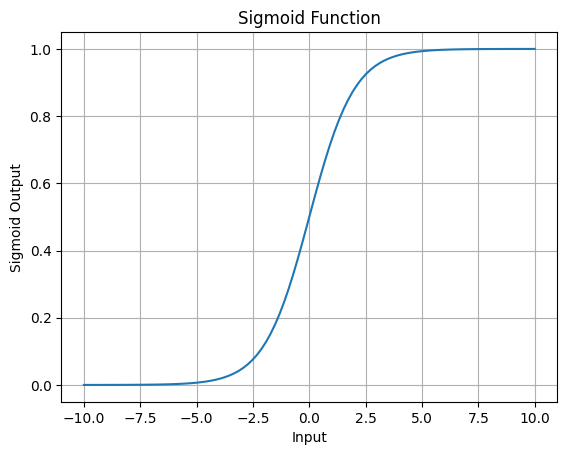

In [4]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    '''
    Applies the sigmoid activation function on input values.

    Args:
      - x (numpy.ndarray): array of values from each neuron of a given layer, ranging from -infinity to infinity.

    Returns:
      - activation (numpy.ndarray): array of sigmoid activation values between 0 and 1. 
                                    Outputs are non-exclusive, i.e, the sum of the values don't add up to 1.
    '''
    return 1.0 / (1 + np.exp(-x))

#input_ = [x for x in range(-20, 20)] # List of 40 numbers from -20 to 20.
input_ = np.linspace(-10, 10, 100).astype('float32') # Array of 100 numbers from -10 to 10.
#input_ = np.arange(-20, 20, .1).astype('float32') # Array with Start: -20, Stop: 20, Step: 1.
output = [sigmoid(x) for x in input_]

plt.plot(input_, output)
plt.xlabel("Input")
plt.ylabel("Sigmoid Output")
plt.title("Sigmoid Function")
plt.grid(True)
plt.show()

## Softmax

The softmax activation function is used for multi-class classification. It normalizes the outputs to produce a probability distribution over all classes.

\begin{align}
softmax(x_i) = \frac{e^{x_i}}{\sum{e^{x_j}}}.
\end{align} 

- Input: [-infinity, infinity]. 
- Output: [0, 1]. 
- The sum of the probabilities must be equal to 1.

A more stable version for NumPy implementation is:

\begin{align}
softmax(x_i) = \frac{\gamma e^{x_i}}{\gamma \sum{e^{x_j}}} = \frac{e^{x_i+ln(\gamma)}}{\sum{e^{x_j+ln(\gamma)}}}.
\end{align} 

A common choice is $ln(\gamma) = -max(x)$.

Sum of probabilities: 0.9999999


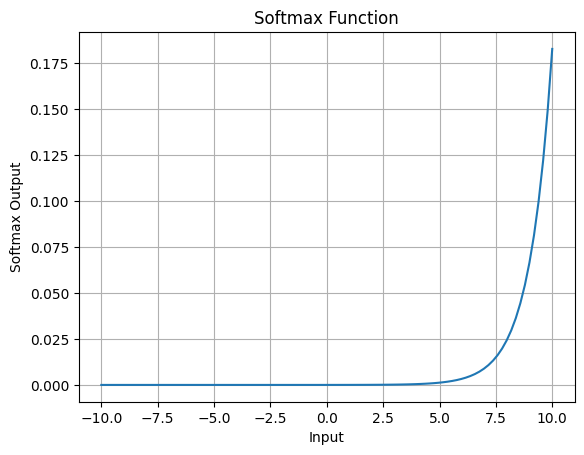

In [5]:
def softmax(x: np.ndarray) -> np.ndarray:
    '''
    Compute the softmax activation function while handling numerical stability.

    Args:
      - x (numpy.ndarray): array of values in the range [-infinity, +infinity].

    Returns:
      - activation (numpy.ndarray): array of softmax activation values in the range [0, 1].
                                    Outputs are exclusive, i.e, the sum of the values add up to 1.    
    '''
    epsilon = 1e-8 # Small number to avoid division by zero.
    expX = np.exp(x - np.max(x)) # Subtracting the maximum value for numerical stability.
    #return expX / (np.sum(expX) + epsilon)
    return expX / (expX.sum(keepdims=True) + epsilon)

input_ = np.linspace(-10, 10, 100).astype('float32') # Array of 100 numbers from -10 to 10.
#input_ = np.random.rand(2, 10).astype('float32')
output = softmax(input_)

print('Sum of probabilities:',output.sum())
plt.plot(input_, output)
plt.xlabel("Input")
plt.ylabel("Softmax Output")
plt.title("Softmax Function")
plt.grid(True)
plt.show()

In [6]:
input_ = np.array([0,  0, 0])
softmax(input_)

array([0.33333333, 0.33333333, 0.33333333])

## Tanh

- `'tanh'`: 
  - Input: [-infinity, infinity].
  - Output: [-1, 1].

\begin{align}
tanh(x_i) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}} = \frac{e^{2x}-1}{e^{2x}+1}
\end{align}   


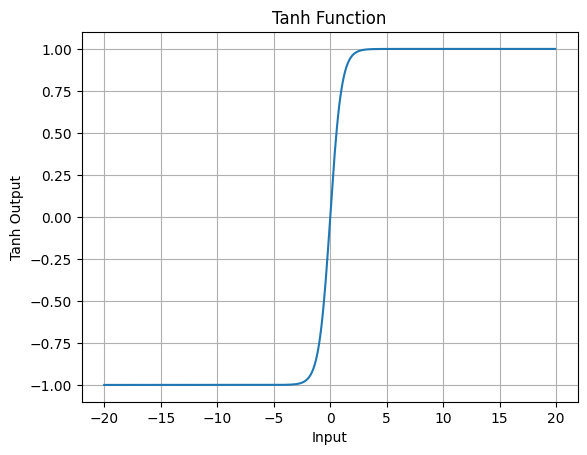

In [7]:
def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

#input = [x for x in range(-20, 20)]
input_ = np.arange(-20, 20, .1).astype('float32')
output = [tanh(x) for x in input_]
plt.plot(input_, output)
plt.xlabel("Input")
plt.ylabel("Tanh Output")
plt.title("Tanh Function")
plt.grid(True)
plt.show()

## ReLU

\begin{eqnarray}
ReLU(x) = max\{0, x\}.
\end{eqnarray}

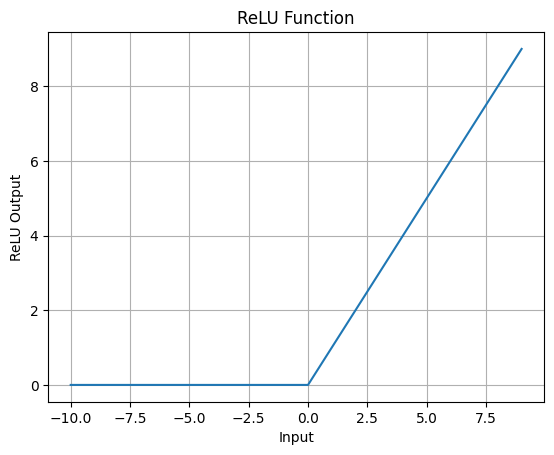

In [8]:
def ReLU(x):
    return max(0.0, x)

#input = [x for x in range(-10, 10)]
input_ = np.arange(-10, 10, 1).astype('float32')
output = [ReLU(x) for x in input_]
plt.plot(input_, output)
plt.xlabel("Input")
plt.ylabel("ReLU Output")
plt.title("ReLU Function")
plt.grid(True)
plt.show()

## GeLU

# <font color='orange'> Loss Functions in Python and Keras API </font><a name="Implementation" />

## MSE Loss

Mean squared error (MSE) loss function is a non-convex function, i.e, it has more than one minimum, possibly many local minimum.

\begin{eqnarray}
MSE &=& \frac{1}{N}\sum_{i=1}^{N} (y_i - \hat{y}_i)^2.
\end{eqnarray}

Legend:

- $y_i$: ground truth value (label) for the $i$-th data point (sample).
- $\hat{y}_i$: predicted value for the $i$-th data point (sample).
- $N$: the number of samples in a batch of data.

In [9]:
def mse(y_pred: np.ndarray, y_true: np.ndarray) -> np.float64:
    '''
    Calculates the Mean Squared Error (MSE) loss between the predicted and actual values.

    Args:
      - y_pred (numpy.ndarray): 2D array (num_samples, num_features) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_features) of ground truth values.

    Returns:
      - loss (numpy.float64): mean squared error loss.
    '''
    err = y_pred - y_true
    loss = np.mean(np.square(err))
    return loss

# Or equivalently:

def mse2(y_pred, y_true, M):
    err = y_pred - y_true
    loss = np.sum(np.square(err))/M
    return loss

In [10]:
y_pred = np.array([3, -0.5, 2, 7], dtype=np.float32)
y_true = np.array([2.5, 0.0, 2, 8], dtype=np.float32)

mse(y_pred, y_true), mse2(y_pred, y_true, len(y_pred))

(0.375, 0.375)

Check this result with [Keras API](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [11]:
tf.keras.losses.MSE(y_pred,y_true)

<tf.Tensor: shape=(), dtype=float32, numpy=0.375>

## MSE with L2

\begin{eqnarray}
MSE_{L_2}  &=& \text{MSE} + L_2 \\
&=&  \frac{1}{N}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \lambda \sum_{i=1}^L ||\mathbf{W}^{(l)}||^2. \\
&=&  \frac{1}{N}\sum_{i=1}^{N} (y_i-\hat{y}_i)^2 + \lambda \sum_{i=1}^L \sum_{j,k} \mathbf{w}_{jk}^2. \\
\end{eqnarray}

Legend:

- $y_i$: ground truth value (label) for the $i$-th data point (sample).
- $\hat{y}_i$: predicted value for the $i$-th data point (sample).
- $L$ is the number of weight matrices in the neural network.
- $\mathbf{w}_{jk}^{2}$ is the square value of the $j$-th weight for the $i$-th matrix.
- $\lambda$ is the regularization coefficient, a value between 0 and 0.1.

In [24]:
def mse_l2(y_hat: np.ndarray, y_true: np.ndarray, weights: List[np.ndarray], regularization_coeff: float) -> np.float32:
    '''
    Calculates the Mean Squared Error (MSE) loss with L2 regularization between the predicted and actual values.

    Args:
      - y_hat (numpy.ndarray): 2D array (num_samples, num_features) of predicted values.
      - y_true (numpy.ndarray): 2D array (num_samples, num_features) of ground truth values.
      - weights (List[numpy.ndarray]): list of weight matrices in the network (including hidden layers and output layer).
      - regularization_coeff (float): regularization coefficient for L2 regularization.

    Returns:
      - loss (numpy.float32): mean squared error loss with L2 regularization.
    '''
    err = y_hat - y_true
    loss = np.mean(np.square(err))

    regularization_term = 0.0
    for weight_matrix in weights:
        regularization_term += np.sum(np.square(weight_matrix))

    loss += (regularization_coeff / 2) * regularization_term

    return loss.astype(np.float32)

In [13]:
# Example usage:

y_hat = np.array([[0.8, 0.2], [0.6, 0.4]])  # Predicted values.
y_true = np.array([[1.0, 0.0], [0.7, 0.3]]) # Ground truth values.
weights = [np.random.rand(2, 4), np.random.rand(4, 2)] # Sample weight matrices.
regularization_coeff = 0.01

loss = mse_l2(y_hat, y_true, weights, regularization_coeff)
print("MSE Loss with L2 Regularization:", loss)

MSE Loss with L2 Regularization: 0.047092877


## Binary Cross-Entropy

The binary cross-entropy function measures the dissimilarity or information loss between the predicted probability and the true label of a single sample. It is used in classification tasks with only two classes.

\begin{eqnarray}
BCE \equiv H(y, \hat{y}) = - \left( y \cdot \mathrm{log}\; {\hat{y}} + (1-y) \cdot \mathrm{log}\; (1-{\hat{y}}) \right).
\end{eqnarray}

Legend:

- $log(x)$: is the natural logarithm of $x$.
- $y$: is the actual label (ground truth value) of the sample. Either 0 (negative class) or 1 (positive class).
- $\hat{y}$: is the predicted probability for the positive class.
- $(1-\hat{y})$: is the predicted probability for the negative class.

In [14]:
def binary_cross_entropy(y_true: float, y_hat: float) -> float:
    '''
    Binary cross-entropy function.
    
    Args:
        - y_true (float): actual label (ground truth value) of the sample. Either 0 or 1.
        - y_hat (float): predicted probability for the positive class. A number between 0 and 1.
    
    Returns:
        - bce (float): binary cross-entropy value.    
    '''
    bce = -(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
    return bce

In [15]:
# Example usage:
    
# One sample:
print("Binary Cross-Entropy of one sample:", binary_cross_entropy(0, 0.1))

# Two samples:
print("Mean Binary Cross-Entropy of two samples:",(binary_cross_entropy(0, 0.1)+binary_cross_entropy(1, 0.9))/2)

Binary Cross-Entropy of one sample: 0.10536051565782628
Mean Binary Cross-Entropy of two samples: 0.10536051565782628


## Binary Cross-Entropy Loss

The binary cross-entropy loss function is the mean average of the binary cross entropy over a batch of data. 

\begin{eqnarray}
BCE_{loss} = \frac{1}{N}\sum_{i=1}^N BCE(y_i, \hat{y}_i) = - \frac{1}{N}\sum_{i=1}^N y_i \cdot \mathrm{log}\; {\hat{y}}_i + (1-y_i) \cdot \mathrm{log}\; (1-{\hat{y}}_i).
\end{eqnarray}

Legend:

- $BCE(y_i, \hat{y}_i)$: is the binary cross-entropy value of the $i$-th sample.
- $y_i$: is the actual label (ground truth value) of the $i$-th sample. Either 0 (negative class) or 1 (positive class).
- $\hat{y}_i$: is the predicted probability for the positive class of the $i$-th sample.
- $(1-\hat{y}_i)$: is the predicted probability for the negative class of the $i$-th sample.
- $N$: is the number of samples in a batch of data.

In binary classification, the output layer of a neural network typically consists of a single neuron with sigmoid activation function or two neurons with softmax activation function. The value of each neuron in the output layer represents the predicted probability of a specific class.

Note: the implementation **does not require target labels to be one-hot encoded**.

In [16]:
def bce_loss1(y_true: np.ndarray or list, y_hat: np.ndarray or list) -> np.float32:
    '''
    Computes the binary cross-entropy loss function.
    Uses list comprehension to iterate over the elements of y_true and y_hat and summing up the values.
    
    Args:
      - y_true (numpy.ndarray or list): is the target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray or list): is the array of predicted probabilities.
      
    Returns:
      - mean_loss (numpy.float32): binary cross-entropy loss. Mean average of the binary cross entropy.
    '''
    n_samples = len(y_true)
    loss = -sum([(y_true[i]*np.log(y_hat[i])+(1-y_true[i])*np.log(1-y_hat[i])) for i in range(n_samples)])
    mean_loss = loss/n_samples
    return mean_loss.astype(np.float32)

In [17]:
# Creating arrays of two samples:
y_true = [0, 1]
y_pred = [0.1, 0.9]

bce_loss1 = bce_loss1(y_true, y_pred)
bce_loss1

0.105360515

In [18]:
def bce_loss2(y_true: np.ndarray or list, y_hat: np.ndarray or list) -> np.float32:
    '''
    Computes the binary cross-entropy loss function.
    Uses conditional statements.
    
    Args:
      - y_true (numpy.ndarray): is the target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray): is the array of predicted probabilities.
      
    Returns:
      - loss (numpy.float32): binary cross-entropy loss. Mean average of the binary cross entropy.
    '''
    for i in range(len(y_true)):
        if y_true[i] == 1:
            return -np.log(y_hat[i]).astype(np.float32)
        else:
            return -np.log(1 - y_hat[i]).astype(np.float32)

In [19]:
bce_loss2 = bce_loss2(y_true, y_pred)
bce_loss2

0.105360515

In [20]:
def bce_loss3(y_true: np.ndarray, y_hat: np.ndarray) -> np.float32:
    '''
    Computes the binary cross-entropy loss function.
    Uses NumPy's broadcasting to compute the cross-entropy loss for all input samples simultaneously.
    
    Args:
      - y_true (numpy.ndarray): is the target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray): is the array of predicted probabilities.
      
    Returns:
      - loss (numpy.float32): binary cross-entropy loss. Mean average of the binary cross entropy.
    '''
    loss = -np.mean(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
    return loss.astype(np.float32)

In [21]:
y_true = np.array([0, 1])
y_pred = np.array([0.1, 0.9])

y_true.shape, y_true.ndim

((2,), 1)

In [22]:
bce_loss3 = bce_loss3(y_true, y_pred)
bce_loss3

0.105360515

In [23]:
bce_loss1 == bce_loss2 == bce_loss3

True

[Check the result with Keras](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy):

In [24]:
bce_keras = tf.keras.losses.BinaryCrossentropy()
bce_keras = bce_keras(y_true, y_pred).numpy()
bce_keras

0.1053604045467214

In [25]:
# Comparing values up to 6 decimal places:
round(bce_keras, 6), round(bce_loss2, 5)

(0.10536, 0.10536)

## Categorical Cross-Entropy

Categorical cross-entropy is a dissimilarity measure between predicted probability distributions and true labels. It is used in classification tasks with more than two classes.

\begin{eqnarray}
CCE &=& -\sum_{i=1}^C y_i \cdot \mathrm{log}\; (\hat{y}_i).
\end{eqnarray}

Legend:

- $log(x)$: is the natural logarithm of $x$.
- $y_i$: is the ground truth value corresponding to class $i$. Either 0 or 1.
- $\hat{y}_i$: is the predicted probability that observation (sample) $\hat{O}$ is of class $i$.
- $C$: number of classes.

Upon expanding the sum, since there is only one non-zero label $y_i$, the equation can be further simplified to:

\begin{eqnarray}
CCE &=& - \mathrm{log}\; (\hat{y}_c),
\end{eqnarray}

where $\hat{y}_c$ is the predicted probability for the correct class.

Note: **target labels are required to be one-hot encoded**.

In [26]:
# Creating array of one sample and three classes:
y_true = np.array([0, 1, 0]) # One-hot encoding.
y_pred = np.array([0.05, 0.94, 0.01])

y_true.shape, y_true.size, y_true.ndim

((3,), 3, 1)

In [27]:
def categorical_cross_entropy(y_true: np.ndarray, y_hat: np.ndarray) -> np.float32:
    '''
    Computes the categorical cross-entropy function.
    
    Args:
      - y_true (numpy.ndarray): the one-hot encoded target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray): the array of predicted probabilities.
    
    Returns:
      - cce (numpy.float32): categorical cross-entropy value.    
    '''
    eps = 1e-15 # Add a small value to y_hat to avoid taking the logarithm of zero.
    cce = -np.sum(y_true * np.log(y_hat + eps))
    return cce.astype(np.float32)

In [28]:
# Example usage:

print("Categorical cross-entropy with three classes:", categorical_cross_entropy(y_true, y_pred))

Categorical cross-entropy with three classes: 0.061875403


## Categorical Cross-Entropy Loss

The categorical cross-entropy loss is the mean average of the categorical cross-entropy function over a batch of data. 

\begin{eqnarray}
CCE_{loss} &=& -\frac{1}{N}\sum_{i=1}^N (CCE)_i.
\end{eqnarray}

Legend:

- $(CCE)_i$: categorical cross-entropy value of the $i$-th sample.
- $N$: the number of samples in a batch of data.

In multi-class classification, the output layer of a neural network has as many neurons as there are classes and the activation function is typically softmax. The value of each neuron in the output layer represents the predicted probability of a specific class. **Target labels are required to be one-hot encoded**.

In [29]:
# Creating array of two samples and three classes:
y_true = np.array([[0, 1, 0], [0, 0, 1]]) # One-hot encoding.
y_pred = np.array([[0.05, 0.94, 0.01], [0.1, 0.8, 0.1]])

y_true.shape, y_true.size, y_true.ndim

((2, 3), 6, 2)

In [30]:
def cce_loss1(y_true: np.ndarray, y_hat: np.ndarray) -> np.float32:
    '''
    Computes the multi-class (categorical) cross-entropy loss function.
    Uses NumPy's broadcasting to compute the cross-entropy loss for all input examples simultaneously.
    
    Args:
      - y_true (numpy.ndarray): 2D target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray): 2D array of predicted probabilities.
      
    Returns:
      - loss (numpy.float32): categorical cross-entropy loss value.
    '''
    eps = 1e-15 # Add a small value to y_hat to avoid taking the logarithm of zero.
    #y_hat = np.clip(y_hat, eps, 1 - eps) # Clip y_hat to the range [epsilon, 1 - epsilon].
    #n_samples = y_true.shape[0]
    #loss = -np.sum(y_true * np.log(y_hat)) / n_samples
    loss = -np.mean(np.sum(y_true * np.log(y_hat + eps), axis=1))
    return loss.astype(np.float32)

In [31]:
# Example usage:

cce_loss1 = cce_loss1(y_true, y_pred)
print("Categorical cross-entropy loss for two samples and three classes:", cce_loss1)

Categorical cross-entropy loss for two samples and three classes: 1.1822302


In [32]:
mean_cce = (categorical_cross_entropy(y_true[0], y_pred[0])+categorical_cross_entropy(y_true[1], y_pred[1]))/2
mean_cce = mean_cce.astype(np.float32)

assert cce_loss1 == mean_cce, "Test case failed."
print("Test case passed!")

Test case passed!


In [33]:
def cce_loss2(y_true: np.ndarray, y_hat: np.ndarray) -> np.float32:
    '''
    Computes the multi-class (categorical) cross-entropy loss function.
    Uses list comprehension.

    Args:
      - y_true (numpy.ndarray): target array of true labels (ground truth probabilities).
      - y_hat (numpy.ndarray): array of predicted probabilities.
      
    Returns:
      - loss (numpy.float32): categorical cross-entropy loss value. Mean average of categorical cross-entropy.
    '''
    eps = 1e-15 # Add a small value to y_hat to avoid taking the logarithm of zero.
    loss = np.mean([-np.sum(y_true[i]*np.log(y_hat[i] + eps)) for i in range(len(y_true))])
    return loss.astype(np.float32)

In [34]:
cce_loss2 = cce_loss2(y_true, y_pred)
print("Categorical cross-entropy loss for two samples and three classes:", cce_loss2)

Categorical cross-entropy loss for two samples and three classes: 1.1822302


In [35]:
# Comparing values up to 7 decimal places:
round(cce_loss1, 7) == round(cce_loss2, 7)

True

[Checking the result with tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy):

In [36]:
y_true = [1, 2] # Label encoding.
y_pred = [[0.05, 0.94, 0.01], [0.1, 0.8, 0.1]]
scce = tf.keras.losses.SparseCategoricalCrossentropy()
scce = scce(y_true, y_pred).numpy()
scce

1.1822302

In [37]:
los = tf.keras.losses.SparseCategoricalCrossentropy()

y_true = np.array([[0, 1, 0], [0, 0, 1]]) # One-hot encoding.
y_pred = np.array([[0.05, 0.94, 0.01], [0.1, 0.8, 0.1]])

cce_keras = tf.keras.losses.CategoricalCrossentropy() 
cce_keras = cce_keras(y_true, y_pred).numpy().astype(np.float32)
cce_keras

1.1822302

In [38]:
scce == cce_keras == cce_loss1 == cce_loss2

True

## Sparse Categorical Cross-Entropy Loss

This loss is specifically designed for scenarios where the target labels are integers rather than one-hot encoded vectors. When using this loss in keras, there is no need to use a Dense layer with a softmax activation as the output layer. Keras will handle internally the conversion of logits to probabilities during training.

```python
model = keras.Sequential()
model.add(...)
model.add(Dense(nr_of_classes))
```

# <font color='orange'> Backpropagation </font><a name="Implementation" />

See the following resource for a visualization of the backpropagation algorithm:
    
1. [3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

- Gradient descent: is an **optimizer** whose objective is to update the weights of the neural network in order to minimize the value of the loss function. To do so it calculates the gradient of the loss function w.r.t the weights via an algorithm called backpropagation. This gradient is a vector where each component of the vector is the derivative of the loss ($\mathcal{L}$) with respect to the weights ($w_{kj}$) and biases ($b_j$).
<br>

- Backpropagation: is the computation of the chain rule¹ of calculus used to calculate the gradient of the loss function starting from the output layer and going backwards to the input layer. It uses the chain rule because the loss function depends of the output activation function which in turn depends on the previous activations and weights, i.e, a composition of functions.
<br>

- In SGD, as the size of the parameter vector we are trying to optimize gets larger (like a million), any local minima is as good as a global minima. Ps: I heard that in a keynote from David Silver, and I agree.

**Note:** there are several other optimizers available to replace gradient descent, such as Adam, AdaGrad, Adadelta and RMSProp, to name a few.

---
¹Chain rule is the derivative of the composition of two or more functions. 

## Neural Network Layers

**Definitions:**

- $\hat{y}$: predicted value.
- $y$: ground truth.
- $y_j$: the ground truth value (expected value) of node $j$ in a hidden layer $l$. Is a parameter (a constant value).
- NN: short for "Neural Network".
- $L$: total number of layers in the NN.
- $N$: total number of neurons (a.k.a nodes) in a given layer.
- $l (l= 1, 2, 3, \cdots, L-1)$: index of the nth-hidden layer in the NN.
- $j (j=0,1,2, \cdots, N-1)$: index for nodes in a hidden layer.
- $k (k=0,1,2, \cdots, N-1)$: index for nodes in the output layer $L$.
- $\mathcal{L}$: loss function of the output layer $L$.
- $w_{i\rightarrow j}$: is the matrix of weights (sinapses) that connects the output of neuron $n_i$ in layer $l-1$ to the input of neuron $n_j$ in layer $l$.
- $w_{j}^l$: vector containing all the weights connected to node $j$ in layer $l$ by each node in the previous layer indexed by $l-1$. This is a fully connected NN.
- $s_{j}^{(l)}$: input of node $j$ in layer $l$.
- $g^{(l)}$: activation function of layer $l$. There is one activation function for each neuron. A given layer has the same activation function for all of its neurons.
- $z_j^{(l)}$: activation output of node $j$ in layer $l$. 
- $b_j$: bias for each node in layer $l$.

How to read $a_j^{(l)}$: "$a$ sub $j$ superscript $l$".

**Dense (fully connected) layers have the following algebra:**

Input of node $j$ in layer $l$ is given by a weighted sum:

\begin{eqnarray}
s_j^{(l)} = \sum_{i=0}^{N-1} w_{i \rightarrow j}^l z_i^{(l-1)}+b_j^{(l)}.
\end{eqnarray}

Activation output of node $j$ in layer $l$:

\begin{eqnarray}
z_j^{(l)} = g^{(l)}(s_j^{(l)}) = g^{(l)}\left(\sum_{i=0}^{N-1} w_{i\rightarrow j}^l z_i^{(l-1)}+b_j^{(l)}\right).
\end{eqnarray}

| Convention     | Activation Shape     | Weight Shape                   | Formula                                                         
|----------------|----------------------|--------------------------------|-----------------------------
| Column vector  | `(n × 1)`            | `(n_out × n)`                  | $s_j^{(l)} = w_{i \rightarrow j}^l z_i^{(l-1)}+b_j^{(l)}$
| Row vector     | `(1 × n)`            | `(n × n_out)`                  | $s_j^{(l)} = z_i^{(l-1)} w_{i \rightarrow j}^l + b_j^{(l)}$

Where `n` and `n_out` are the number of input and output neurons in the weight matrix of the $l$-th layer, respectively.

## The backpropagation algorithm

- Step 1. Use the chain rule to compute the gradient of the loss function which is a composite function of activations and weights.

\begin{align*}
\frac{\partial(\text{loss})}{\partial (\text{weight})} = \frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}^{(l)}} = \frac{\partial \mathcal{L}}{\partial z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial s_k^{(l)}}\frac{\partial s_k^{(l)}}{\partial w_{j\rightarrow k}^{(l)}}.
\end{align*}

By definition of the weighted sum, the last term is:

\begin{align*}
\frac{\partial s_k}{\partial w_{j\rightarrow k}^{(l)}} = \frac{\partial}{\partial w_{j\rightarrow k}^{(l)}}\left(\sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} z_j^{(l-1)}+b_k^{(L)} \right) = z_j^{(l-1)} \frac{\partial}{\partial w_{j\rightarrow k}^{(l)}} \sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} = z_j^{(l-1)}.
\end{align*}

With that:

\begin{align*}
\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}^{(l)}} =  \left(\frac{\partial \mathcal{L}}{\partial z_k^{(l)}}\frac{\partial z_k^{(l)}}{\partial s_k^{(l)}} \right) z_k^{(l-1)} := \delta_k^{(l)} \cdot z_j^{(l-1)}.
\end{align*}

- Step 1.1 Compute $\delta_k$ for node $k$ in output layer $L$:

$$\delta_k = \left(\frac{\partial \mathcal{L}}{\partial z_{k}^{(L)}}\right)\left(\frac{\partial z_k^{(L)}}{\partial s_{k}^{(L)}}\right).$$

- Step 1.2 Compute $\delta_j$ for node $j$ in hidden layer $l$:

$$\delta_j = \left(\frac{\partial \mathcal{L}}{\partial z_j^{(l)}}\frac{\partial z_j^{(l)}}{\partial s_j^{(l)}} \right).$$

- Step 2. Update weights via Gradient Descent (GD) with learning rate $\eta$:

$$w_{j+1} = w_j - \eta \frac{\partial \mathcal{L}}{\partial w_{i\rightarrow j}^{(l)}} = w_j - \eta (\delta_j^l \cdot z_j^{(l-1)}).$$

- Step 3. Update biases via Gradient Descent (GD) with learning rate $\eta$:

$$b_{j+1} = b_j -  \eta \frac{\partial \mathcal{L}}{\partial b_{j}^{(l)}} = b_j - \eta \delta_j^l.$$

## Backpropagation for MSE loss and Sigmoid activation function

### Computing the gradient for node $k$ in output layer $L$

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \underbrace{\Big(\frac{\partial \mathcal{L}}{\partial z_k}\frac{\partial z_k}{\partial s_k}\Big)}_{\delta_k}  \frac{\partial s_k}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} \cdot z_k^{(L-1)}.$$

- The first term of $\delta_k$ is:

$$\frac{\partial \mathcal{L}}{\partial z_k} =\frac{\partial}{\partial z_k} \left(\frac{1}{2}\sum_{k \in L=1}^{2} (z_k-y_k)^2 \right)= (z_k - y_k).$$

To see why, expand the series:

\begin{eqnarray}
\frac{\partial \mathcal{L}}{\partial z_{1}} =  \frac{\partial}{\partial z_1}\frac{\left(\sum_{j=0}^{n} (z_j - y_j)^2 \right)}{2}= \frac{\partial}{\partial z_1}\frac{(z_0 -y_0)^2}{2}+\frac{\partial}{\partial z_1}\frac{(z_1 -y_1)^2}{2}+\cdots +\frac{\partial}{\partial z_1}\frac{(z_n -y_n)^2}{2}= (z_1 -y_1).
\end{eqnarray}

- The second term of $\delta_k$ is:

$$\frac{\partial z_k}{\partial s_k} = \frac{\partial}{\partial s_k} (\sigma (s_k)) = \frac{\partial}{\partial s_k} \Bigg(\frac{1}{1+e^{-s_k}}\Bigg).$$

Using the chain rule of calculus

$$\frac{d}{dx}\left(f(g(x))\right) = f'(g(x)) \cdot g'(x),$$

the Sigmoid derivative is

\begin{align}
\frac{\partial}{\partial x} \Bigg(\frac{1}{1+e^{-x}}\Bigg) &= \frac{\partial}{\partial x} \Big(1+e^{-x}\Big)^{-1}\\ 
&= -\Big(1+e^{-x}\Big)^{-2} \cdot \frac{\partial}{\partial x} \Big (1+e^{-x}\Big) \\
&=-\Big(1+e^{-x}\Big)^{-2} \cdot (- e^{-x})\\
&= e^{-x}\Big(1+e^{-x}\Big)^{-2} \\
&= \frac{1}{1+e^{-x}}\frac{e^{-x}}{1+e^{-x}}\\
&= \frac{1}{1+e^{-x}}\frac{1+e^{-x}-1}{1+e^{-x}}\\
&= \frac{1}{1+e^{-x}}\Bigg(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\Bigg)\\
&=\sigma(x) (1-\sigma(x)).
\end{align} 

One then has

$$\frac{\partial z_k^{(L)}}{\partial s_k} = \frac{\partial}{\partial s_k} (\sigma (s_k^{(L)})) = \sigma(s_k) (1-\sigma(s_k))= z_k(1-z_k).$$

**The complete gradient for the output layer thus becomes:**

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)} - y_k)z_k^{(L)}(1-z_k^{(L)})z_k^{(L-1)}.$$

### Computing the gradient for the hidden layers

The following math takes in consideration that `Sigmoid` is also used in the hidden layers.

$$\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}^{(L-1)}} = \underbrace{\Big(\frac{\partial \mathcal{L}}{\partial z_j^{(L-1)}}\frac{\partial z_j^{(L-1)}}{\partial s_j^{(L-1)}}\Big)}_{\delta_j}  \frac{\partial s_j^{(L-1)}}{\partial w_{i\rightarrow j}^{(L-1)}} = \delta_j^{l} \cdot z_j^{(l-1)}.$$

One can see that the only difference here is the index changed, $k \rightarrow j$, as we backpropagate from a node $n_k$ in the output layer $L$ to a node $n_j$ in the hidden layer $L-1$.

- The first term of $\delta_j$ is (for an arbitrary layer $l$):

\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_j^{(L-1)}} =  \sum_{k \in l=1}^N \frac{\partial \mathcal{L}}{\partial z_k}\frac{\partial z_k}{\partial s_k}\frac{\partial s_k}{\partial z_j} :=  \sum_{k \in l=1}^N  \delta_k \frac{\partial s_k}{\partial z_j}.
\end{align*}

With

\begin{align*}
\frac{\partial s_k}{\partial z_j} = \frac{\partial}{\partial z_j} \left(\sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} z_j^{(l-1)}+b_k \right) = 
 w_{j \rightarrow k}^{(l)} \cdot \sum_{j=0}^{N-1} \frac{\partial}{\partial z_j} (z_j^{(l-1)}) = w_{j \rightarrow k}^{(l)}.
\end{align*}

Then

\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_j^{(L-1)}} =  \sum_{k \in L=1}^N \delta_k^{(L)} w_{j\rightarrow k}^{(L)}.
\end{align*}

- The second term of $\delta_j$ is (as before):

$$\frac{\partial z_j^{(L-1)}}{\partial s_j} = \frac{\partial}{\partial s_j} (\sigma (s_j)) = \frac{\partial}{\partial s_j} \Bigg(\frac{1}{1+e^{-s_j}}\Bigg) =  z_j(1-z_j).$$

**The complete gradient for the hidden layer thus becomes:**

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}} = \underbrace{\Big(\frac{\partial \mathcal{L}}{\partial z_j}\Big)}_\text{1st term} \Big( \frac{\partial z_j}{\partial s_j}\Big) \Big(\frac{\partial s_j}{\partial w_{i\rightarrow j}}\Big)=\delta_j^{(l)} z_j^{(l-1)}=\underbrace{\left(\sum_{k \in l=1}^N \delta_k^{(l+1)} w_{j\rightarrow k}\right)}_\text{1st term} \left(z_{j}^{(l)}(1-z_{j}^{(l)}) \right)z_j^{(l-1)}.
\end{align*}

### Summary

- Output layer:

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k z_k^{(l-1)} = (z_k - y_k)z_k(1-z_k)z_k^{(l-1)}.$$

- Hdden layer:

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}} =\delta_j z_j^{(l-1)}=\left(\sum_{k \in l=1}^N \delta_k^{(l+1)} w_{j\rightarrow k}\right) z_{j}^{(l)}(1-z_{j}^{(l)})z_j^{(l-1)}.
\end{align*}

## Backpropagation for Categorical Cross-Entropy loss and Softmax activation function

### Computing the gradient for node $k$ in output layer $L$

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \underbrace{\Big(\frac{\partial \mathcal{L}}{\partial z_k}\frac{\partial z_k}{\partial s_k}\Big)}_{\delta_k}  \frac{\partial s_k}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)}.$$

- The first term of $\delta_k$ is:

\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_k} &= \frac{\partial}{\partial  z_k}\left(-\sum_{i=1}^N y_i \cdot \mathrm{log}\ (z_i)\right) =  - \sum_{i=1}^N y_i \frac{\partial}{\partial z_k} \mathrm{log}(z_i) = - \sum_{i=1}^N y_i \frac{\partial (\mathrm{log}(z_i))}{\partial z_i} \frac{\partial z_i}{\partial z_k} \delta_{ik} =  - \sum_{i=1}^N y_i \frac{1}{z_i} \frac{\partial z_i}{\partial z_k}\delta_{ik} = - \sum_{k=1}^N \frac{y_k}{z_k}.
\end{align*}

Where $\delta_{ik}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta) used to impose $i=k$ (a.k.a contraction), otherwise the result would be zero. Since due to the summation, at least one element from the derivative is different than zero.

- The second term of $\delta_k$ is:

$$\frac{\partial z_k^{(L)}}{\partial s_k} = \frac{\partial}{\partial s_k} (\sigma (s_k^{(L)})) = \frac{\partial}{\partial s_k} \Bigg(\frac{e^{s_k}}{\sum_i e^{s_i}}\Bigg).$$

Recall the quotient rule of Calculus for derivatives:

$$\frac{d}{dx}\left(\frac{f(x)}{g(x)}\right) = \frac{g(x) \cdot f'(x) - f(x) \cdot g'(x)}{[g(x)]^2}.$$



Since all possible combinations need to be evaluated, one takes the derivative w.r.t a different index. 

For the numerator (using the chain rule):

\begin{equation}
f'(x) = \frac{\partial}{\partial s_j} (e^{s_k}) = \frac{\partial (e^{s_k})}{\partial s_k} \cdot \frac{\partial (s_k)}{\partial s_j} = e^{s_k} \frac{\partial s_k}{\partial s_k} \cdot \frac{\partial (s_k)}{\partial s_j} = 
\begin{cases}
e^{s_k} &\text{if } k=j, \\
0 &\text{if } k \ne j.
\end{cases}
\end{equation}

For the denominator:

\begin{equation}
g'(x) = \frac{\partial}{\partial s_j} \Big(\sum_{i=1}^n e^{s_i}\Big) = e^{s_i}\delta_{ij} =  e^{s_j}. 
\end{equation}

Again, because of the summation, Kronecker delta can be used to indicate that the derivative is non-zero only when the indices match.

**The Softmax derivative for $k=j$:**

\begin{align}
\frac{\partial}{\partial s_j} \Bigg(\frac{e^{s_k}}{\sum_i{e^{s_i}}}\Bigg) &= \frac{(\sum_i{e^{s_i}})e^{s_k}-e^{s_k} e^{s_j}}{(\sum_i{e^{s_i}})^2} = \frac{e^{s_k}}{\sum_i{e^{s_i}}}\Bigg(1-\frac{e^{s_j}}{\sum_i{e^{s_i}}} \Bigg) \delta_{jk}
= softmax(s_k)\Bigg(1-softmax(s_k)\Bigg) = z_k(1-z_k).
\end{align} 

**The Softmax derivative for $k \ne j$:**

\begin{align}
\frac{\partial}{\partial s_j} \Bigg(\frac{e^{s_k}}{\sum_i{e^{s_i}}}\Bigg) &= 
\frac{0-e^{s_k}e^{s_j}}{(\sum_i{e^{s_i}})^2}= -\frac{e^{s_k}}{\sum_i{e^{s_i}}}\frac{e^{s_j}}{\sum_i{e^{s_i}}}=-softmax(s_k)\cdot softmax(s_j) = -z_kz_j.
\end{align} 

Combining both cases, one then gets:
    
\begin{eqnarray}
\delta_k^{(L)} = \Big(\frac{\partial \mathcal{L}}{\partial z_k}\frac{\partial z_k}{\partial s_j}\Big) 
&=& - \sum_{k=1}^N \frac{y_k}{z_k} \frac{\partial z_k}{\partial s_j} \\
&=& - \sum_{k=1}^N \frac{y_k}{z_k} z_j (\delta_{kj} - z_k)\\
&=& - \sum_{k=1}^N \frac{y_k}{z_k} z_k(1-z_k) - \sum_{j=1, j\ne k}^N  \frac{y_j}{z_j}  \Big(-z_j z_k\Big) \\
&=& - \frac{y_k}{z_k} z_k(1-z_k) - \sum_{j=1, j\ne k}^N  \frac{y_j}{z_j}  \Big(-z_j z_k\Big) \\
&=& - y_k+y_k z_k+\sum_{j=1, j\ne k}^N y_j z_k \\
&=& - y_k + z_k\Big(y_k + \sum_{j=1, j\ne k}^N y_j \Big)\\
&=& - y_k + z_k \underbrace{\Big(\sum_{j=1}^N y_j \Big)}_\text{=1}\\
&=& - y_k + z_k = z_k - y_k.
\end{eqnarray}

Recall that $y_k$ is the ground truth probability distribution and, therefore, it adds up to one.

**The complete gradient for the output layer thus becomes:**

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)}-y_k) z_k^{(L-1)}.$$

### Computing the gradient for the hidden layers

- **First approach:**

$$\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}^{(l-1)}} = \underbrace{\Big(\frac{\partial \mathcal{L}}{\partial z_j^{(l-1)}}\frac{\partial z_j^{(l-1)}}{\partial s_j^{(l-1)}}\Big)}_{\delta_j}  \frac{\partial s_j^{(l-1)}}{\partial w_{i\rightarrow j}^{(l-1)}} = \delta_j^{l} \cdot z_j^{(l-1)}.$$

The first term of $\delta_j$ (for an arbitrary layer $l$) is :

\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_j^{(l-1)}} =  \sum_{k \in l=1}^N \Big(\frac{\partial \mathcal{L}}{\partial z_k}\frac{\partial z_k}{\partial s_k}\Big)\frac{\partial s_k}{\partial z_j} =  \sum_{k \in l=1}^N  (z_k^{(l)}-y_k) \frac{\partial s_k}{\partial z_j}.
\end{align*}

With

\begin{align*}
\frac{\partial s_k}{\partial z_j} = \frac{\partial}{\partial z_j} \left(\sum_{j=0}^{N-1} w_{j \rightarrow k} z_j^{(l-1)}+b_k \right) = 
 w_{j \rightarrow k}^{(l)} \cdot \sum_{j=0}^{N-1} \frac{\partial}{\partial z_j} (z_j^{(l-1)}) = w_{j \rightarrow k}.
\end{align*}

Hence,

\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_j^{(l-1)}} =  \sum_{k \in L=1}^N (z_k^{(l)}-y_k) w_{j\rightarrow k}.
\end{align*}

The second term of $\delta_j$ is:

\begin{align*}
\frac{\partial z_j^{(l-1)}}{\partial s_j^{(l-1)}} = \sigma'(s_j^{(l-1)}).
\end{align*}

Finally, 

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}^{(l-1)}} =  \sum_{k \in l=1}^N (z_k^{(l)}-y_k) w_{j\rightarrow k} \sigma'(s_j^{(l-1)})z_{j}^{(l-2)}.
\end{align*}

- **Second approach:**


$$\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}^{(l-1)}} = \frac{\partial \mathcal{L}}{\partial s_j^{(l-1)}} \frac{\partial s_j^{(l-1)}}{\partial w_{i\rightarrow j}^{(l-1)}} = \frac{\partial \mathcal{L}}{\partial s_j^{(l-1)}} z_{j}^{(l-2)}.$$

The first term has the following chain rule:

\begin{align*}
\frac{\partial \mathcal{L}}{\partial s_j^{(l-1)}} =  \sum_{k \in l=1}^N \frac{\partial \mathcal{L}}{\partial s_k^{(l)}}\frac{\partial s_k^{(l)}}{\partial z_j^{(l-1)}}\frac{\partial z_j^{(l-1)}}{\partial s_j^{(l-1)}}.
\end{align*}

Where:

\begin{align*}
\frac{\partial \mathcal{L}}{\partial s_k^{(l)}} = \Big(\frac{\partial \mathcal{L}}{\partial z_j}\frac{\partial z_j}{\partial s_k}\Big)  = z_k^{(l)}-y_k.
\end{align*}

\begin{align*}
\frac{\partial s_k^{(l)}}{\partial z_j^{(l-1)}} = \frac{\partial}{\partial z_j^{(l-1)}} \left(\sum_{j=0}^{N-1} w_{j \rightarrow k}^{(l)} z_j^{(l-1)}+b_k \right) = 
 w_{j \rightarrow k}^{(l)} \cdot \sum_{j=0}^{N-1} \frac{\partial}{\partial z_j^{(l-1)}} (z_j^{(l-1)}) = w_{j \rightarrow k}^{(l)}.
\end{align*}

\begin{align*}
\frac{\partial z_j^{(l-1)}}{\partial s_j^{(l-1)}} = \sigma'(s_j^{(l-1)}).
\end{align*}

Finally, 

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}^{(l-1)}} =  \sum_{k \in l=1}^N (z_k^{(l)}-y_k) w_{j\rightarrow k} \sigma'(s_j^{(l-1)})z_{j}^{(l-2)}.
\end{align*}

### Summary

- Output layer:

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)}-y_k) z_k^{(L-1)}.$$

- Hdden layer:

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}} =\delta_j z_j^{(l-2)} = \Big((z_k^{(l)}-y_k) w_{j\rightarrow k} \sigma'(s_j^{(l-1)}) \Big) z_j^{(l-2)}.
\end{align*}

## Backpropagation for Categorical Cross-Entropy loss with Softmax in the output layer and Sigmoid in the hidden layers

In this case, the gradient for the output layer is the one considering Softmax. And the gradient for the hidden layers is the one considering Sigmoid. 

Those results have already being calculated before.

- Output layer with Softmax:

$$\frac{\partial \mathcal{L}(z_k(s_k(w_k)))}{\partial w_{j\rightarrow k}} = \delta_k^{(L)} z_k^{(L-1)} = (z_k^{(L)}-y_k) z_k^{(L-1)}.$$

- Hdden layer with Sigmoid:

\begin{align*}
\frac{\partial \mathcal{L}(z_j(s_j(w_j)))}{\partial w_{i\rightarrow j}} =\delta_j z_j^{(l-1)}=\left(\sum_{k \in l=1}^N \delta_k^{(l+1)} w_{j\rightarrow k}\right) z_{j}^{(l)}(1-z_{j}^{(l)})z_j^{(l-1)}.
\end{align*}